# Построение многослойного персептрона для решения задачи классификации
Определение модели с нуля, включая описание алгоритмов оптимизации достаточно трудоемко. Вместо этого TensorFlow предоставляет уже определенные слои через библиотеку tf.keras.layers, которые могут быть легко использованы в качестве строительных блоков нейросетевой модели. В этом разделе будет разобрано, как использовать эти слои для решения задачи классификации с использованием набора данных Iris flower и построения двухслойного персептрона с использованием Keras API. Сначала необходимо получить данные из tensorflow_datasets.

In [1]:
import tensorflow_datasets as tfds
iris, iris_info = tfds.load('iris', with_info=True)
print(iris_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\acer\tensorflow_datasets\iris\2.0.0.incompleteL2U15G\iris-train.tfrecord*...:   0%|        …

Dataset iris downloaded and prepared to C:\Users\acer\tensorflow_datasets\iris\2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.0.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_path='C:\\Users\\acer\\tensorflow_datasets\\iris\\2.0.0',
    file_format=tfrecord,
    download_size=4.44 KiB,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=float32),
        'label': ClassLabel(shape=(), dtype=int6

Можно видеть, что при этом выводится сводная информация о датасете. Можно видеть, что этот набор данных поставляется только с одним разделом, поэтому его необходимо разделить на обучающий и тестовый разделы (и валидационный для правильной практики машинного обучения) самостоятельно. 

Предположим, что мы хотим использовать две трети набора данных для обучения и сохранить оставшиеся примеры для тестирования. Библиотека tensorflow_datasets предоставляет удобный инструмент, который позволяет нам определять срезы и разбиения с помощью объекта DatasetBuilder перед загрузкой набор данных. 

Студенты, заинтересованные в том, чтобы детальнее разобраться в работе с датасетами, могут сделать по ссылке в сети Интернет:  https://www.tensorflow.org/datasets/splits.
Альтернативный подход заключается в том, чтобы сначала загрузить весь набор данных, а затем использовать .take() и .skip(), чтобы разделить набор данных на два раздела. Если набор данных сначала не перетасовывается, его можно также перетасовать. Однако необходимо быть очень осторожными с этим, потому что смешивание может привести к смешиванию обучающих / тестовых примеров, что неприемлемо в машинном обучении. Чтобы избежать этого, мы должны задать аргумент reshuffle_each_iteration=False в методе .shuffle(). Код для разделения набора данных на тестовый и обучающий выглядит следующим образом:

In [3]:
import tensorflow as tf
tf.random.set_seed(1)
ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)
ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

Далее, как мы уже видели в предыдущих разделах, нужно применить преобразование с помощью метода .map(), чтобы сформировать из словаря кортеж:

In [4]:
ds_train_orig = ds_train_orig.map(lambda x: (x['features'], x['label']))
ds_test = ds_test.map(lambda x: (x['features'], x['label']))

Мы готовы перейти к построению нейросетевой модели с помощью API Keras.
Будем использовать класс tf.keras.Sequential, с помощью которого можно сформировать модель из нескольких слоев Keras. Со списком и описаниями всех слоев Keras можно ознакомиться по следующей ссылке в сети Интернет: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers.
Для решения задачи мы собираемся использовать полносвязный (FC), состоящий из персептронов, слой Dense (tf.keras.слои.Плотный), который может быть наилучшим образом представлен с помощью функции 𝑓(𝑤 × 𝑥 + 𝑏), где x - входные характеристики, w и b - весовая матрица и вектор смещения, а f - функция активации.
Стоит помнить, что в нейронных сетях каждый слой получает свои входные данные от предыдущего слоя; следовательно, его размерность (ранг и форма) фиксирована. Соответственно, о размерности выходных данных следует помнить только в момент проектирования нейросети. 

**Примечание:** первый слой является исключением, TensorFlow/Keras позволяет определять размерность входных данных первого слоя после определения модели посредством позднего создания переменной. 

В данном примене мы хотим определить модель с двумя скрытыми слоями.
Первый получает входные данные из четырех признаков и проецирует их на 16 нейронов. Второй слой получает выходные данные предыдущего слоя (который имеет размер 16) и проецирует их на три выходных нейрона, поскольку у нас есть три метки класса. Это можно сделать, используя класс Sequential и слой Dense в Keras следующим образом:

In [5]:
iris_model = tf.keras.Sequential([
tf.keras.layers.Dense(16, activation='sigmoid',name='fc1', input_shape=(4,)),
tf.keras.layers.Dense(3, name='fc2', activation='softmax')])
iris_model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


Обратите внимание, что мы определили входную форму для первого слоя с помощью input_shape=(4,), и, следовательно, нам больше не нужно было вызывать .build(), чтобы использовать iris_ model.summary().
В распечатанной сводке модели указано, что первый слой (fc1) имеет 80 параметров, а второй слой имеет 51 параметр. Вы можете убедиться в этом с помощью ($𝑛_{i}$𝑖𝑛 + 1) × $𝑛_{n}$out , где $𝑛_{i}$𝑖𝑛 - это количество входных единиц, а $𝑛_{n}$out - количество выходных единиц. Напомним, что для полностью (плотно) связанного слоя изучаемыми параметрами являются весовая матрица размера $𝑛_{i}$𝑖𝑛 × $𝑛_{n}$out и вектор смещения размера $𝑛_{n}$out. Кроме того, обратите внимание, что мы использовали сигмоидную функцию активации для первого слоя и softmax для последнего (выходного) слоя. Функция активация Softmax на последнем слое используется для поддержки многоклассовой классификации, поскольку в данной задаче необходимо разделить три метки классов (именно поэтому у нас есть три нейрона на выходном уровне). Далее в этой главе обсудим различные функции активации и их применение.
Далее мы скомпилируем эту модель, чтобы указать функцию ошибки, оптимизатор и показатели для оценки:

In [6]:
iris_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Теперь мы можем обучить модель. Мы укажем количество эпох равным 100, а размер пакета - 2. В следующем коде мы создадим бесконечно повторяющийся набор данных, который будет передан методу fit() для обучения модели. В этом случае, для того чтобы метод fit() мог отслеживать эпохи, ему необходимо знать количество шагов для каждой эпохи.
Учитывая размер наших обучающих данных (здесь 100) и размер пакета (batch_size), мы можем определить количество шагов в каждой эпохе, steps_per_epoch:

In [8]:
import numpy as np
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)

history = iris_model.fit(ds_train, epochs=num_epochs, steps_per_epoch=steps_per_epoch, verbose=0)

Возвращаемая переменная history сохраняет потери при обучении и точность обучения (поскольку они были указаны в качестве показателей для iris_model.compile()) после каждой эпохи. Мы можем использовать это для визуализации кривых обучения следующим образом. Программа в следующем фрагменте демонстрирует кривые обучения (ошибка при обучении и точность предсказания)

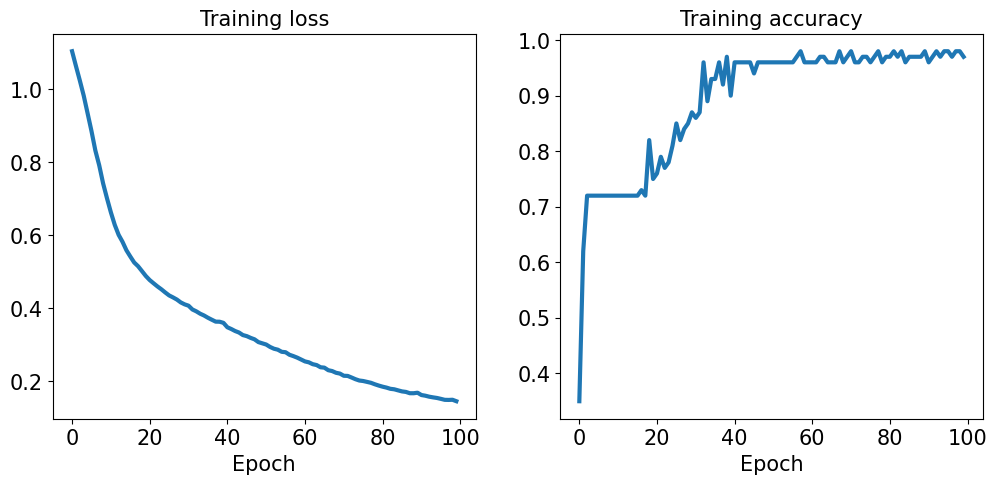

In [10]:
import matplotlib.pyplot as plt
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

## Оценка обученной модели на основе тестового набора данных
Поскольку  в качестве нашей оценочной метрики в iris_model.compile() была указана указали accuracy ("точность"), то теперь на основе этой метрики можно оценить модель на тестовом наборе данных.

In [14]:
results = iris_model.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f} Test Acc.: {:.4f}'.format(*results)) 

Test loss: 0.1479 Test Acc.: 0.9600


Следует обратить внимание, что при решении задачи необходимо выполнить упаковку тестового набора данных, чтобы убедиться, что входные данные для модели имеют правильную размерность (ранг). Как мы обсуждали ранее, вызов .batch() увеличит ранг извлеченных тензоров на 1. Входные данные для .evaluate() должны иметь одно назначенное измерение для пакета, хотя здесь (для оценки) размер пакета не имеет значения. Следовательно, если мы передадим ds_batch.batch(50) методу .evaluate(), весь тестовый набор данных будет обработан в одном пакете размером 50, но если мы передадим ds_batch.batch(1), будет обработано 50 пакетов размером 1.

## Сохранение и загрузка обученной модели
Обученные модели можно сохранить на диске для дальнейшего использования. Делается это следующим образом:

In [15]:
iris_model.save('iris-classifier.h5', overwrite=True, include_optimizer=True, save_format='h5')

Первый параметр - это имя файла. Вызов iris_model.save() сохранит как архитектуру модели, так и все значения синаптических весов модели. Если необходимо сохранить только архитектуру, то следует использовать метод iris_model.to_json(), который сохраняет конфигурацию модели в формате JSON. Если вы хотите сохранить только веса модели, вы можете сделать это, вызвав iris_model.save_weights(). Параметр save_format определяет формат файла сохранения и может быть указан как "h5" для формата HDF5 или "tf" для формата TensorFlow.


Теперь сохраненную модель можно считать из папки сохранения. Поскольку мы сохранили как архитектуру модели, так и веса, мы можем легко перестроить и перезагрузить параметры нейросети всего в одной строке:

In [16]:
iris_model_new = tf.keras.models.load_model('iris-classifier.h5')

Проверить архитектуру модели можно, вызвав iris_model_new.summary().
Загруженную модель можно оценить на тестовом наборе данных, чтобы убедиться, что результаты такие же, как и раньше.

In [17]:
results = iris_model_new.evaluate(ds_test.batch(33), verbose=0)
print('Test loss: {:.4f}	Test Acc.: {:.4f}'.format(*results))

Test loss: 0.1479	Test Acc.: 0.9600


Таким образом, мы прошли базовый цикл создания, обучения и тестирования нейросети при помощи библиотеки TensorFlow, а также сохранения и считывания модели.